REBOUND RV and Plotting function
====================================

In [1]:
import numpy as np
import numpy.random as rd
import os
import rebound
import mr_forecast as mr
# radvel paper https://arxiv.org/abs/1801.01947
# radvel github https://github.com/California-Planet-Search/radvel
import radvel
import corner
import copy
import scipy
from scipy import optimize
from radvel.plot import orbit_plots
# Dan's stability model packages
import random
import dill
import sys
import pandas as pd
if not '../MLstability/generate_training_data' in sys.path:
    sys.path.append('../MLstability/generate_training_data')
from training_data_functions import ressummaryfeaturesxgb
# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


In [2]:
folderpath = '../MLstability'
model = 'ressummaryfeaturesxgb_resonantAMD.pkl'
model, features, featurefolder = dill.load(open(folderpath+'/models/'+model, "rb"))

In [3]:
seconds_p_day = 86400
days_p_year = 365.25
meters_p_AU = 149597870700
earth_mass_2_solar_mass = 0.000003003
year_p_reboundtime = 1 / (2 * np.pi)

def build_sim(Ps, ms, system="test", id_=0, es=0, incs=0, Mstar=1):
    
    Nplanets = len(Ps)
    
    if all(es==0):
        es = np.zeros(Nplanets)
        
    assert Nplanets==len(ms)==len(es)
    
    name = "%s_%d"%(system,id_)

    radii = np.zeros(Nplanets)
    for i in range(Nplanets):
        radii[i] = (1 - es[i]) * np.cbrt(Ps[i] * Ps[i] * ms[i] * earth_mass_2_solar_mass / Mstar / 3) / 2

    #set up simulation
    sim = rebound.Simulation()

    sim.collision = 'line'

    #add star
    sim.add(m=Mstar)
    # sim.add(m=Ms, r=radii[0]*10**(-3))

    seconds_p_day = 86400

    if all(incs==0):
        a = np.cbrt(Ps * Ps)
        Rs2AU = 0.00465047
        Rstar = 1
        incs=np.array([rd.uniform(high=0.9 * Rstar * Rs2AU / a[i]) for i in range(Nplanets)])
    
    Ws=2 * np.pi * rd.sample(Nplanets)
    ws=2 * np.pi * rd.sample(Nplanets)
    Ms=2 * np.pi * rd.sample(Nplanets)
    for i in range(Nplanets):
        m = ms[i] * earth_mass_2_solar_mass
        P = Ps[i]
        e = es[i]
        inc = incs[i]
        W = Ws[i]
        w = ws[i]
        M = Ms[i]
        sim.add(m=m, P=P / year_p_reboundtime, e=e, inc=inc, Omega=W, omega=w, M=M, r=radii[i]) #G=1 units!
    sim.move_to_com()
    
    #save simulation archive
    # dir_path = os.path.dirname(os.path.realpath(__file__)) #directory of this program
#     dir_path = os.getcwd()
#     out_dir = dir_path + "/output/"
#     os.system('mkdir %s'%out_dir)
#     out_dir=out_dir + "%s/"%system
#     os.system('mkdir %s'%out_dir)

#     sim.automateSimulationArchive(out_dir + '%s_SA.bin'%name, interval=last_time / 1000 / year_p_reboundtime, deletefile=True) #save checkpoints.

    return sim

def rebound_rvs(times, sim):
    
    assert np.all(np.diff(times)>=0), "times passed aren't sorted"
    
    times_rb = times / year_p_reboundtime
    
    rvs = np.zeros(len(times))
    for i in range(len(times)):
        sim.integrate(times_rb[i])
        rvs[i] = sim.particles[0].vx
    rvs = rvs * meters_p_AU / year_p_reboundtime / days_p_year / seconds_p_day
    return rvs
    
def a_normal(mean, upper_sigma, lower_sigma):
    draw = rd.normal()
    if draw > 0:
        draw *= upper_sigma
    else:
        draw *= lower_sigma
    return draw + mean

# Convenient function for plotting fits
def plot_results(like):
    ti = np.linspace(np.min(t), np.max(t), 1000)
    fig = plt.gcf()
    plt.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.draw()

def VSA(P, m_star, m_planet, e, i):
    m_planet *= earth_mass_2_solar_mass
    comb_mass = m_star + m_planet
    return 2 * np.pi * np.sin(i) * m_planet / (np.sqrt(1 - (e * e)) * np.cbrt(comb_mass * comb_mass * P))* meters_p_AU / seconds_p_day / days_p_year

def approx_mass_from_VSA(P, m_star, K, e, i):
    return K / (earth_mass_2_solar_mass * 2 * np.pi * np.sin(i) * meters_p_AU / seconds_p_day / days_p_year) * (np.sqrt(1 - (e * e)) * np.cbrt(m_star * m_star * P))

In [4]:
# VSA(1, 1, 1, 0, np.pi/2)
approx_mass_from_VSA(1, 1, 0.089, 0, np.pi/2)

0.9950235533750172

Getting RVs
====================================

Inserting planets from Vanderburg et al. 2019

https://arxiv.org/abs/1905.05193

In [ ]:
# mb = mr.Rstat2M(2.085, 0.066, return_post=True)
# mc = mr.Rstat2M(1.939, 0.069, return_post=True)
# md = mr.Rstat2M(2.164, 0.085, return_post=True)

In [5]:
# Ps = np.array([a_normal(3.58599, 0.00015, 0.00015), a_normal(5.97293, 0.00060, 0.00053), a_normal(11.2300, 0.0011, 0.0010)]) / days_p_year  # years
# ms = np.array([rd.choice(mb), rd.choice(mc), rd.choice(md)])  # earth masses
# es = np.array([rd.rand() * 0.3, rd.rand() * 0.19, rd.rand() * 0.28])
# incs = np.pi / 180 * np.array([a_normal(85.5, 1.5, 0.5), a_normal(86.23, 0.26, 0.26), a_normal(87.43, 0.18, 0.19)])
# score: 0.99971646
ms = np.array([6.46921898, 3.77262505, 4.94023659])
Ps = np.array([0.00981711, 0.01635166, 0.03074497])
es = np.array([0.02633058, 0.00219933, 0.02240356])
incs = np.array([1.48292398, 1.50449052, 1.52583569])
n_meas = 200
t = 0.5 * np.sort(rd.rand(n_meas))
Mstar = 1.145
sim = build_sim(Ps, ms, Mstar=Mstar, es=es, incs=incs - np.pi/2)

In [6]:
# %%time
# args = (10000, 1000) # (Norbits, Nout) Keep this fixed
# summaryfeatures = pd.DataFrame([ressummaryfeaturesxgb(sim, args)])
# stability_score = model.predict_proba(summaryfeatures)[:, 1][0]
# print(stability_score)

In [8]:
sim = build_sim(Ps, ms, Mstar=Mstar, es=es, incs=incs)
syn_rv = rebound_rvs(t, sim)
errvel = 0.1
jitter = 0.5 # replace with GP?
syn_rv += rd.randn(n_meas)*np.sqrt(errvel**2 + jitter**2)

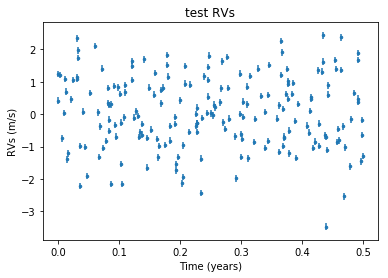

In [9]:
plt.errorbar(t, syn_rv, yerr=errvel, fmt='.')
plt.xlabel("Time (years)")
plt.ylabel("RVs (m/s)")
plt.title("test RVs")
plt.show()

In [10]:
# radvel uses days
Ps *= days_p_year
t *= days_p_year

Creating radvel model
====================================

In [45]:
params = radvel.Parameters(3, basis='per tc secosw sesinw k')
params['per1'] = radvel.Parameter(value=Ps[0])
params['tc1'] = radvel.Parameter(value= 2458409.18969)
params['secosw1'] = radvel.Parameter(value=np.sqrt(es[0]))
params['sesinw1'] = radvel.Parameter(value=0)
params['k1'] = radvel.Parameter(value=VSA(Ps[0] / days_p_year, Mstar, ms[0], es[0], incs[0]))

params['per2'] = radvel.Parameter(value=Ps[1])
params['tc2'] = radvel.Parameter(value=2458415.6344)
params['secosw2'] = radvel.Parameter(value=np.sqrt(es[1]))
params['sesinw2'] = radvel.Parameter(value=0)
params['k2'] = radvel.Parameter(value=VSA(Ps[1] / days_p_year, Mstar, ms[1], es[1], incs[1]))

params['per3'] = radvel.Parameter(value=Ps[2])
params['tc3'] = radvel.Parameter(value=2458409.7328)
params['secosw3'] = radvel.Parameter(value=np.sqrt(es[2]))
params['sesinw3'] = radvel.Parameter(value=0)
params['k3'] = radvel.Parameter(value=VSA(Ps[2] / days_p_year, Mstar, ms[2], es[2], incs[2]))

# params['dvdt'] = radvel.Parameter(value=0)
# params['curv'] = radvel.Parameter(value=0)

rv_mod = radvel.RVModel(params)

Generate likelihood
====================================

In [46]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod, t, syn_rv, np.zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=jitter)

like_syn.params['jit'].vary = False # Don't vary jitter
like_syn.params['per1'].vary = False # Don't vary period
like_syn.params['per2'].vary = False # Don't vary period
like_syn.params['per3'].vary = False # Don't vary period
like_syn.params['dvdt'].vary = False # Don't vary dvdt
like_syn.params['curv'].vary = False # Don't vary curvature
like_syn.params['gamma'].vary = False # Don't vary gamma
print(like_syn)

parameter                     value      vary
per1                         3.5857      False
tc1                         8409.19       True
secosw1                    0.162267       True
sesinw1                           0       True
k1                          2.46043       True
per2                        5.97244      False
tc2                         8415.63       True
secosw2                    0.046897       True
sesinw2                           0       True
k2                          1.21205       True
per3                        11.2296      False
tc3                         8409.73       True
secosw3                    0.149678       True
sesinw3                           0       True
k3                          1.28778       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                             0.5      False



Get MLE just using data
====================================

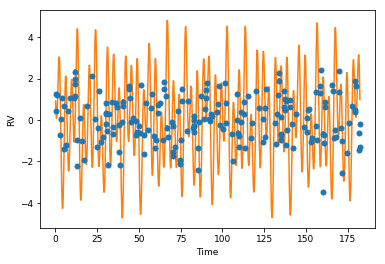

In [47]:
# Plot initial model
plot_results(like_syn) 

parameter                     value      vary
per1                         3.5857      False
tc1                         77529.2       True
secosw1                    0.161651       True
sesinw1                  9.2604e-05       True
k1                          2.40113       True
per2                        5.97244      False
tc2                         52112.5       True
secosw2                   0.0480579       True
sesinw2                 7.05251e-05       True
k2                           1.2044       True
per3                        11.2296      False
tc3                        -76508.8       True
secosw3                    0.150556       True
sesinw3                 4.52252e-05       True
k3                          1.27335       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                             0.5      False



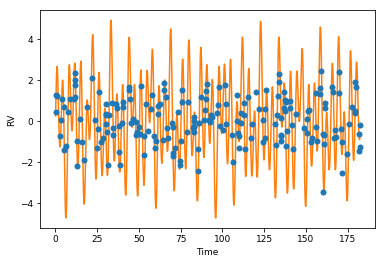

In [48]:
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead')
# res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B')
# print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Initialize posterior and add priors
====================================

In [15]:
%%time
sample = int(1e3 * 10)
mb = mr.Rstat2M(2.085, 0.066, return_post=True, sample_size=sample, grid_size=sample)
mc = mr.Rstat2M(1.939, 0.069, return_post=True, sample_size=sample, grid_size=sample)
md = mr.Rstat2M(2.164, 0.085, return_post=True, sample_size=sample, grid_size=sample)

In [54]:
post = radvel.posterior.Posterior(like_syn)

# https://radvel.readthedocs.io/en/latest/prior.html for implementing priors

# post.priors += [radvel.prior.EccentricityPrior(3, 0.3)]
post.priors += [radvel.prior.EccentricityPrior(np.array([1]), 0.3 / 1)]
post.priors += [radvel.prior.EccentricityPrior(np.array([2]), 0.19 / 2)]
post.priors += [radvel.prior.EccentricityPrior(np.array([3]), 0.28 / 3)]

post.priors += [radvel.prior.NumericalPrior(['k1'], VSA(Ps[0], Mstar, mb, es[0], incs[0]))]
post.priors += [radvel.prior.NumericalPrior(['k2'], VSA(Ps[1], Mstar, mc, es[1], incs[1]))]
post.priors += [radvel.prior.NumericalPrior(['k3'], VSA(Ps[2], Mstar, md, es[2], incs[2]))]

def myPriorFunc(inp_list):
    
    eccentricities = np.array([
        inp_list[3] ** 2 + inp_list[4] ** 2,
        inp_list[5] ** 2 + inp_list[6] ** 2,
        inp_list[7] ** 2 + inp_list[8] ** 2])
    
    masses = np.array([
        approx_mass_from_VSA(Ps[0], Mstar, inp_list[0], eccentricities[0], incs[0]),
        approx_mass_from_VSA(Ps[1], Mstar, inp_list[1], eccentricities[1], incs[1]),
        approx_mass_from_VSA(Ps[2], Mstar, inp_list[2], eccentricities[2], incs[2])])
    
    sim = build_sim(Ps, masses, Mstar=Mstar, es=eccentricities, incs=incs - np.pi/2)
    args = (10000, 1000) # (Norbits, Nout) Keep this fixed
    summaryfeatures = pd.DataFrame([ressummaryfeaturesxgb(sim, args)])
    return model.predict_proba(summaryfeatures)[:, 1][0]

post.priors += [radvel.prior.UserDefinedPrior(['k1', 'k2', 'k3', 'secosw1', 'sesinw1', 'secosw2', 'sesinw2', 'secosw3', 'sesinw3'], myPriorFunc, 'Stability Prior')]

print("Before fitting\n")
print(post)

Before fitting

parameter                     value      vary
per1                         3.5857      False
tc1                         77529.2       True
secosw1                    0.161651       True
sesinw1                  9.2604e-05       True
k1                          2.40113       True
per2                        5.97244      False
tc2                         52112.5       True
secosw2                   0.0480579       True
sesinw2                 7.05251e-05       True
k2                           1.2044       True
per3                        11.2296      False
tc3                        -76508.8       True
secosw3                    0.150556       True
sesinw3                 4.52252e-05       True
k3                          1.27335       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                             0.5      False

Priors
------
e1 constrained to be < 0.3
e2 

Fit based on priors
====================================

In [ ]:
%%time
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead')
plot_results(post.likelihood)
print("After fitting\n")
print(post)

In [ ]:
import pickle

In [ ]:
pkl_file = 'post_fit_w_priors.pickle'

with open(pkl_file, 'wb') as f:
    pickle.dump(post, f)

# with open(pkl_file, 'rb') as f:
#     var_you_want_to_load_into = pickle.load(f)

In [ ]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

Use mcmc to sample the posterior distribution and corner to visualize
========================

In [ ]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

pkl_file = 'mcmc_fit_w_priors.pickle'

with open(pkl_file, 'wb') as f:
    pickle.dump(df, f)

# with open(pkl_file, 'rb') as f:
#     var_you_want_to_load_into = pickle.load(f)

In [ ]:
labels = [k for k in post.params.keys() if post.params[k].vary]

# fig = corner.corner(
#     df[labels],
#     labels=labels,
#     truths=[truths[k].value for k in labels ],
#     quantiles=[0.15,0.85],
#     plot_datapoints=False,
#     smooth=True,
#     bins=20
#     )
fig = corner.corner(
    df[labels],
    labels=labels,
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

In [ ]:
hist(df.lnprobability)

In [ ]:
for i in range(len(es)):
    print(es[i])
    plt.figure()
    plt.hist(df["sesinw%d"%(i+1)]**2 + df["secosw%d"%(i+1)]**2, density=True)